<a href="https://colab.research.google.com/github/GoogTech/langchain-tutorials/blob/master/Agents/Build_an_RAG_1.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Refer to the langchain tutorials of `v0.3` : https://python.langchain.com/docs/tutorials/rag/

# Overview

A typical RAG application has two main components:

* `Indexing`: a pipeline for ingesting data from a source and indexing it. This usually happens offline.

* `Retrieval and generation`: the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.

## Indexing

1. `Load`: First we need to load our data. This is done with Document Loaders.
2. `Split`: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and passing it into a model, as large chunks are harder to search over and won't fit in a model's finite context window.
3. `Store`: We need somewhere to store and index our splits, so that they can be searched over later. This is often done using a VectorStore and Embeddings model.

![](https://python.langchain.com/assets/images/rag_indexing-8160f90a90a33253d0154659cf7d453f.png)

## Retrieval and generation

4. `Retrieve`: Given a user input, relevant splits are retrieved from storage using a Retriever.
5. `Generate`: A ChatModel / LLM produces an answer using a prompt that includes both the question with the retrieved data

![](https://python.langchain.com/assets/images/rag_retrieval_generation-1046a4668d6bb08786ef73c56d4f228a.png)

# Installation

In [3]:
!pip install -U  langchain-text-splitters langchain-community langgraph langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.2/150.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip show langchain langgraph langchain_openai

Name: langchain
Version: 0.3.18
Summary: Building applications with LLMs through composability
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: aiohttp, langchain-core, langchain-text-splitters, langsmith, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: langchain-community
---
Name: langgraph
Version: 0.2.72
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-sdk
Required-by: 
---
Name: langchain-openai
Version: 0.3.5
Summary: An integration package connecting OpenAI and LangChain
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: langchain-core, openai, tiktoken
Required-by: 


# 1.Indexing

## 1.1.Loading documents

We need to first load the blog post contents. We can use `DocumentLoaders` for this, which are objects that load in data from a source and return a list of `Document` objects.

In this case we’ll use the `WebBaseLoader`, which uses urllib to load HTML from web URLs and BeautifulSoup to parse it to text.

In [ ]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        # Only keep post title, headers, and content from the full HTML.
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

docs = loader.load()
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43130


## 1.2.Splitting documents

Our loaded document is over 42k characters which is too long to fit into the context window of many models. Even for those models that could fit the full post in their context window, models can struggle to find information in very long inputs.

To handle this we’ll split the `Document` into chunks for `embedding` and `vector storage`. This should help us retrieve only the most relevant parts of the blog post at run time.

In [ ]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 1.Loading documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        # Only keep post title, headers, and content from the full HTML.
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

# 2.Splitting documents
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


## 1.3.Storing documents

Now we need to index our 66 text chunks so that we can search over them at runtime. Following the semantic search tutorial, our approach is to `embed` the contents of each document split and insert these `embeddings` into a `vector store`. Given an input query, we can then use vector search to retrieve relevant documents.

In [22]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from google.colab import userdata

# 1.Loading documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        # Only keep post title, headers, and content from the full HTML.
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

# 2.Splitting documents
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

# 3.Storing documents
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",
    openai_api_key=userdata.get('OPENAI_API_KEY'),
    base_url=userdata.get('BASE_URL'),
)
vector_store = InMemoryVectorStore(embeddings)
document_ids = vector_store.add_documents(documents=all_splits)

# Ouput
print(document_ids[:3],'\n')
for doc in vector_store.store.values():
  print(doc)
  break

['fe12f70d-071f-441d-b291-9d7e42d4a120', 'a86b8397-57fe-46d8-88e3-f3f4a67a0dd1', '13477d5e-c2fb-45b9-bb24-e5dfc95b838f'] 

{'id': 'fe12f70d-071f-441d-b291-9d7e42d4a120', 'vector': [-0.004727883730083704, -0.014942447654902935, -0.01796206645667553, -0.03346485644578934, 0.0010341029847040772, 0.012319736182689667, 0.011237965896725655, 0.036920297890901566, -0.014016326516866684, 0.033371467143297195, 0.022366976365447044, 0.022460365667939186, 0.0019018544116988778, -0.022460365667939186, 0.009471332654356956, 0.03558170422911644, -0.020623689517378807, 0.003480734070762992, -0.015697352588176727, -0.03386954590678215, -0.008086043410003185, 4.1420662455493584e-07, -0.0266006700694561, 0.02331644296646118, 0.01902049034833908, -0.015938609838485718, 0.02462390810251236, 0.01844458281993866, -0.03159705176949501, 0.023145228624343872, 0.032624341547489166, 0.007891479879617691, 0.014732318930327892, -0.022008979693055153, 0.0028328390326350927, -0.033278074115514755, 0.0211373362690210

# 2.Retrieval and Generation

## 2.Prompt

### 2.1.Load Prompt

We’ll use a prompt for RAG that is checked into the LangChain prompt hub (here).

In [ ]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


### 2.2.Customizing the prompt

As shown above, we can load prompts (e.g., this RAG prompt) from the prompt hub. The prompt can also be easily customized. For example:

In [37]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

## 2.2.LangGraph⭐️

⭐️⭐️⭐️ We'll use LangGraph to tie together the retrieval and generation steps into a single application. This will bring a number of benefits:

* We can define our application logic once and automatically support `multiple invocation modes`, including streaming, async, and batched calls.

* We get `streamlined deployments` via LangGraph Platform.

* LangSmith will `automatically trace` the steps of our application together.

* We can `easily add key features` to our application, including `persistence` and `human-in-the-loop approval`, with minimal code changes.


⭐️⭐️⭐️ To use LangGraph, we need to define three things:

1. The `state` of our application;

2. The `nodes` of our application (i.e., application steps);

3. The "`control flow`" of our application (e.g., the ordering of the steps).

#### 2.2.1.State

The state of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a TypedDict, but can also be a Pydantic BaseModel.

For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

In [ ]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

### 2.2.2.Nodes

Nodes (application steps)：Let's start with a simple sequence of two steps: retrieval and generation.

In [ ]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

### 2.2.3.Control flow

Finally, we compile our application into a single `graph` object. In this case, we are just connecting the `retrieval` and `generation` steps into a single sequence.

In [ ]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langgraph.graph import START, StateGraph

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

LangGraph also comes with built-in utilities for visualizing the control flow of your application:



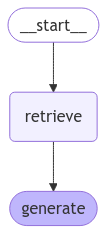

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# 3.Full Code & Summary

In [39]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from google.colab import userdata
from langchain_core.prompts import PromptTemplate
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langgraph.graph import START, StateGraph

#################################################
# 1.Initialize the ChatModel and EmbeddingModel #
#################################################
llm = init_chat_model(
    model="gpt-4o-mini",
    model_provider="openai",
    openai_api_key=userdata.get('OPENAI_API_KEY'),
    base_url=userdata.get('BASE_URL'),
)
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",
    openai_api_key=userdata.get('OPENAI_API_KEY'),
    base_url=userdata.get('BASE_URL'),
)

#######################
# 2.Loading documents #
#######################
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        # Only keep post title, headers, and content from the full HTML.
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

#########################
# 3.Splitting documents #
#########################
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

###########################################################
# 4.Embedding documents and storing them in a vectorstore #
###########################################################
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(documents=all_splits)

##########################################################
# 5.Customizing the prompt or loading it from Prompt Hub #
##########################################################
# prompt = hub.pull("rlm/rag-prompt") # load the prompt from the prompt-hub
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
prompt = PromptTemplate.from_template(template)

##################################################################################################
# 5.Using LangGraph to tie together the retrieval and generation steps into a single application #
##################################################################################################
# 5.1.Define the state of application, which controls the application datas
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# 5.2.1.Define the node of application, which signifies the application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

# 5.2.2.Define the node of application, which signifies the application steps
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

# 6.Define the "control flow" of application, which signifies the ordering of the application steps
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

## 3.1.Usage

Let's test our application! LangGraph supports multiple invocation modes, including sync, async, and streaming.

### 3.3.1.Invoke

In [40]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='85bff4eb-121e-476d-9286-69be880e3ab5', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='46ba8d74-581e-4521-9ab3-8ffb4260ee73', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT b

### 3.3.2.Stream steps

In [41]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='85bff4eb-121e-476d-9286-69be880e3ab5', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='46ba8d74-581e-4521-9ab3-8ffb4260ee73', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 202

### 3.3.3.Stream tokens

In [43]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| decomposition| is| a| technique| that| involves| breaking| down| complex| tasks| into| smaller|,| manageable| steps| to| enhance| performance| and| provide| clarity| in| the| reasoning| process|.| It| can| be| achieved| using| methods| like| Chain| of| Thought| (|Co|T|)| and| Tree| of| Thoughts|,| which| guide| models| to| think| step|-by|-step| or| explore| multiple| reasoning| possibilities|.| This| allows| for| better| planning| and| execution| of| tasks| by| understanding| the| logical| relationships| between| them|.| 

|Thanks| for| asking|!||

### 3.3.4.Async

For async invocations, use:

In [ ]:
# result = await graph.ainvoke(...)

In [ ]:
# async for step in graph.astream(...):

# 4.Query analysis

So far, we are executing the retrieval using the raw input query. However, there are some advantages to allowing a model to generate the query for retrieval purposes. For example:

* In addition to semantic search, we can build in `structured filters` (e.g., "Find documents since the year 2020.");
* The model can `rewrite user queries`, which may be multifaceted or include irrelevant language, into more effective search queries.

Query analysis employs models to transform or construct optimized search queries from raw user input. We can easily incorporate a query analysis step into our application. For illustrative purposes, let's add some metadata to the documents in our vector store. We will add some (contrived) sections to the document which we can filter on later.

In [10]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Loading documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        # Only keep post title, headers, and content from the full HTML.
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

# Splitting documents
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

# Add some metadata to the documents in our vector store.
# so that we can filter on section later.
total_documents = len(all_splits)
third = total_documents // 3
for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

# Output
print(f"Split blog post into `{len(all_splits)}` sub-documents.\n")
print(all_splits[0].metadata)
print(all_splits[32].metadata)
print(all_splits[65].metadata)

Split blog post into `66` sub-documents.

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 8, 'section': 'beginning'}
{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 21623, 'section': 'middle'}
{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 42189, 'section': 'end'}


We will need to update the documents in our vector store. We will use a simple InMemoryVectorStore for this, as we will use some of its specific features (i.e., `metadata filtering`).

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

Let's next define a schema for our search query. We will use structured output for this purpose. Here we define a query as containing a string query and a document section (either "beginning", "middle", or "end"), but this can be defined however you like.

In [ ]:
from typing import Literal
from typing_extensions import Annotated

class Search(TypedDict):
    """Search query."""
    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"], ..., "Section to query."]

Finally, we add a step to our LangGraph application to generate a query from the user's raw input:



In [ ]:
class State(TypedDict):
    question: str
    query: Search # Add the schema of search query
    context: List[Document]
    answer: str

# Add the new node of application,
# which be used to generate a query from the user's raw input
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    # Update the retrieval logic and filter the doc by section
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

# Update the "control flow" of application
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

Full code & Summary:

In [18]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from google.colab import userdata
from langchain_core.prompts import PromptTemplate
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langgraph.graph import START, StateGraph
from typing import Literal
from typing_extensions import Annotated

#################################################
# 1.Initialize the ChatModel and EmbeddingModel #
#################################################
llm = init_chat_model(
    model="gpt-4o-mini",
    model_provider="openai",
    openai_api_key=userdata.get('OPENAI_API_KEY'),
    base_url=userdata.get('BASE_URL'),
)
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",
    openai_api_key=userdata.get('OPENAI_API_KEY'),
    base_url=userdata.get('BASE_URL'),
)

#######################
# 2.Loading documents #
#######################
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        # Only keep post title, headers, and content from the full HTML.
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

#########################
# 3.Splitting documents #
#########################
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

# Search analysis: Add some metadata to the documents in our vector store,
# so that we can filter on section later.
total_documents = len(all_splits)
third = total_documents // 3
for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

# Search analysis: Define the schema for our search query
class Search(TypedDict):
    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"], ..., "Section to query."]

###########################################################
# 4.Embedding documents and storing them in a vectorstore #
###########################################################
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(documents=all_splits)

##########################################################
# 5.Customizing the prompt or loading it from Prompt Hub #
##########################################################
# prompt = hub.pull("rlm/rag-prompt") # load the prompt from the prompt-hub
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
prompt = PromptTemplate.from_template(template)

###################################################################
# 5.Using LangGraph to tie together the analyze_query, retrieval  #
# and generation steps into a single application                  #
###################################################################
# 5.1.Define the state of application, which controls the application datas
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

# Search analysis: Define the node of application,
# which be used to generate a query from the user's raw input
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

# 5.2.1.Define the node of application, which signifies the application steps
def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}

# 5.2.2.Define the node of application, which signifies the application steps
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

# 6.Define the "control flow" of application, which signifies the ordering of the application steps
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

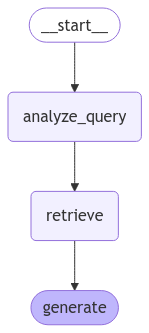

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

We can test our implementation by specifically asking for context from the end of the post. Note that the model includes different information in its answer.

In [21]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='cb4c28ab-e184-44ea-98c3-4f454d3ea3e3', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 33070, 'section': 'end'}, page_content='You will get instructions for code to write.\nYou will write a very long answer. Make sure that every detail of the architecture is, in the end, implemented as code.\nMake sure that every detail of the architecture is, in the end, implemented as code.\nThink step by step and reason yourself to the right decisions to make sure we get it right.\nYou will first lay out the names of the core classes, functions, methods that will be necessary, as well as a quick comment on their purpose.\nThen you will output the content of each file including ALL code.\nEach file must strictly follow a markdown code block format, where the following tokens must be replaced such that\nFILENAME is the lowe

# 5.Brief Summary

We've covered the steps to build a basic Q&A app over data:

1. Loading data with a `Document Loader`
2. `Chunking` the indexed data with a `Text Splitter` to make it more easily usable by a model
3. `Embedding the data` and storing the data in a `vectorstore`
5. `Retrieving` the previously stored chunks in response to incoming `questions`
6. `Generating` an answer using the retrieved chunks as context.